# Part II: Testing Models for Clustering and Cell Type Annotation

## Introduction

In this section, we focus on testing various models for clustering and performing a first attempt at cell type annotation. We build upon our initial data preprocessing and now incorporate treatment information, as well as references from both **CZI** ([Guimarães et al. (2024) Nat Commun](https://cellxgene.cziscience.com/collections/3f7c572c-cd73-4b51-a313-207c7f20f188)) and the **Tabula Muris** skin dataset ([Tabula Muris Tutorial](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scrna/tabula_muris.html)). Our dataset comprises 60 samples, grouped by two time points (8 days and 4 days), and each time point is further organized into 10 subgroups of 3 samples each, resulting in a structured experimental design.

The overall goal here is to integrate treatment, batch, and time point information into a comprehensive analytical framework. This involves dimensionality reduction (PCA), normalization checks, deconvolution strategies, and cell type annotation. By doing so, we aim to better understand the underlying biology and the interplay between technical and biological variation.

## Overview of Analysis Steps

1. **Box Plots of Library Size Before and After Normalization**:  
   We will generate box plots of library sizes, color-coded by treatment and time, both before and after normalization. This will help us assess how normalization affects data distribution across different experimental conditions.

2. **Strategies to Determine Similarity and Clustering**:  
   We will apply three distinct strategies to deconvolve gene expression features, aiming to improve our ability to cluster cells and identify cell populations:
   - **Harmony**: A method for batch correction and integration.
   - **Variational Autoencoder (VAE)**: A deep learning–based approach to model the underlying gene expression distributions.
   - **Probability Modeling**: Statistical methods that model the data distribution to infer underlying cell-type structures.

3. **Automated Cell Type Transfer Using Logistic Regression**:  
   We will employ a logistic regression–based cell typing package to automatically transfer annotations from reference datasets (CZI and Tabula Muris) to our own data. This approach leverages known cell-type profiles to classify cells in our samples.

4. **UMAP Visualization of Clusters by Batch and Treatment**:  
   We will generate UMAP embeddings to visualize clusters resulting from each deconvolution method. By coloring cells by batch and treatment groups, we can visually inspect batch effects and treatment-related changes within the low-dimensional space.

5. **Comparing Batch and Biological Effects**:  
   Finally, we will compare the magnitude of batch effects to the biological effects (e.g., treatment and time points) to understand how effectively our methods separate technical variability from true biological signal.

Overall, this analysis aims to refine our understanding of data structure, improve clustering strategies, and ensure robust and meaningful annotation of cell populations.


```
source myconda  
mamba activate scvi_env
```

In [2]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)


In [1]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

In [6]:
pathout = '/data/kanferg/Sptial_Omics/projects/NguyenLab/spatialomicstoolkit/out_1'
adata_concat = sc.read_h5ad(os.path.join(pathout, "andata_filter_logNorm_hvg.h5ad"))
df = adata_concat.obs[['log1p_total_counts','cell_area','nucleus_area','nucleus_count','batch']]
sorted_categories = sorted(df['batch'].cat.categories, key=lambda x: int(x))
df.loc[:, 'batch'] = df['batch'].cat.reorder_categories(sorted_categories, ordered=True)
sorted_df = df.sort_values(by='batch')
unique_batches_numpy = sorted_df['batch'].cat.categories.to_numpy()

# Overlapping Densities Plot - Library Depth, log-normalized reads count

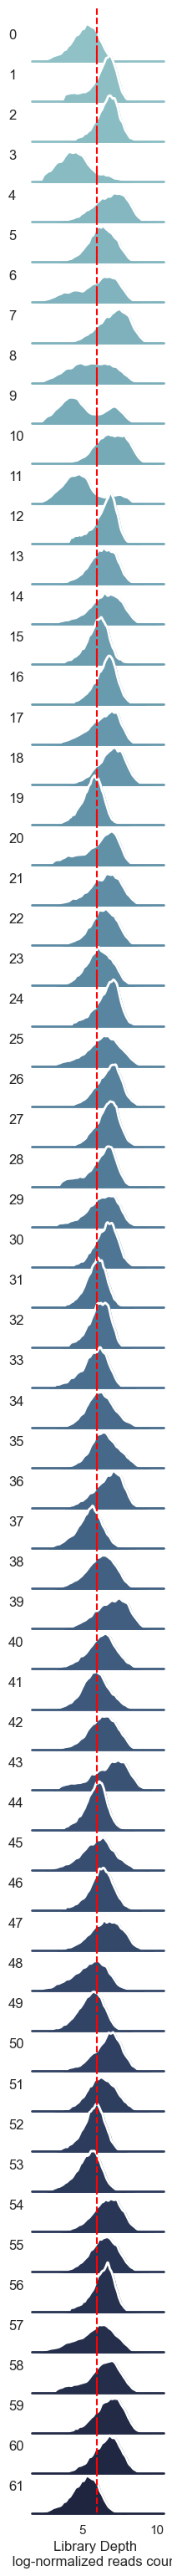

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the theme
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Define palette
pal = sns.cubehelix_palette(len(unique_batches_numpy), rot=-.25, light=.7)

# Initialize FacetGrid
g = sns.FacetGrid(sorted_df, row="batch", hue="batch", aspect=5, height=.5, palette=pal)

# Draw the densities
g.map(sns.kdeplot, "log1p_total_counts", bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "log1p_total_counts", clip_on=False, color="w", lw=2, bw_adjust=.5)


def add_mean_line(**kwargs):
    mean_value = np.round(np.mean(sorted_df['log1p_total_counts'].values),0)
    plt.axvline(mean_value, color='red', linestyle='--', linewidth=1.5)

g.map(add_mean_line)
# Add a reference line
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-0.25)

# Limit the x-axis
#g.set(xlim=(0, 2000))

g.set_titles("")

# Change x-axis label
g.set_axis_labels("Library Depth \n log-normalized reads counts", None)

# Properly align batch labels on the y-axis
for ax, label in zip(g.axes.flat, unique_batches_numpy):
    ax.set_ylabel(f"{label}", rotation=0, ha='left', va='center', labelpad=20)

# Remove unnecessary plot details
g.set(yticks=[])
g.despine(bottom=True, left=True)

# Show plot
plt.show()


In [13]:
def andataADDcovarite_origstring(andtata_in):
    from tqdm import tqdm
    Experimental_design_file = '/data/kanferg/Sptial_Omics/projects/NguyenLab/spatialomicstoolkit/Experimental_design/Experimental_Design.csv'
    ed = pd.read_csv(Experimental_design_file)
    column_sel = ed.columns[2:4].tolist()+ed.columns[5:11].tolist()
    # adding covrites per batch to andata
    for column in column_sel:
        andtata_in.obs[column] = None
        for batch in ed['Polygon']:
            covraite_temp = ed.loc[ed["Polygon"]==batch,column].values.tolist()*len(andtata_in.obs.loc[andtata_in.obs["batch"]==str(batch),column])
            andtata_in.obs.loc[andtata_in.obs["batch"]==str(batch),column] = covraite_temp

In [16]:
andataADDcovarite_origstring(adata_concat)

In [168]:
df = adata_concat.obs[['total_counts','log1p_total_counts','cell_area','nucleus_area','nucleus_count','batch','Condition ','Technical_repeat','Harvest_Day']]
sorted_categories = sorted(df['batch'].cat.categories, key=lambda x: int(x))
df.loc[:, 'batch'] = df['batch'].cat.reorder_categories(sorted_categories, ordered=True)

In [185]:
def run_box(df,condition,ax,column_count = "log1p_total_counts",yaxsis_info = True, y_lim = (0,10),yticks = [2,8],yticks_lab = ['2', '8'], **kwargs):
    if yaxsis_info:
        ax.set_ylim(y_lim[0],y_lim[1])
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticks_lab)  # Set y-axis tick labels explicitly
        # Adjust y-axis tick appearance
        ax.tick_params(axis='y', direction='out', length=5, color='black', width=1)
    df_temp = df.loc[df['Condition ']==condition,:]
    count = 0
    for day in [4, 8]:
        df_temp_con = df_temp.loc[df_temp['Harvest_Day']==day,:]
        unique_cond = pd.unique(df_temp_con['Technical_repeat'])
        for i,un in enumerate(unique_cond):
            cur = df_temp_con.loc[df_temp_con['Technical_repeat']==un,column_count].values
            positions = count
            count +=1
            g = ax.boxplot(x = [cur],
                        positions=[positions],
                        widths=0.5,
                        patch_artist=True,  # Allow color filling
                        boxprops=dict(facecolor="grey" if day==4 else "red", edgecolor="black", linewidth=1.5),  # Customize box style
                        **kwargs
                          )
    ax.set_title(condition)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.tick_params(axis='x', direction='out', length=5, color='black')
    ax.set_ylabel("Library Depth \n (log-normalized)")

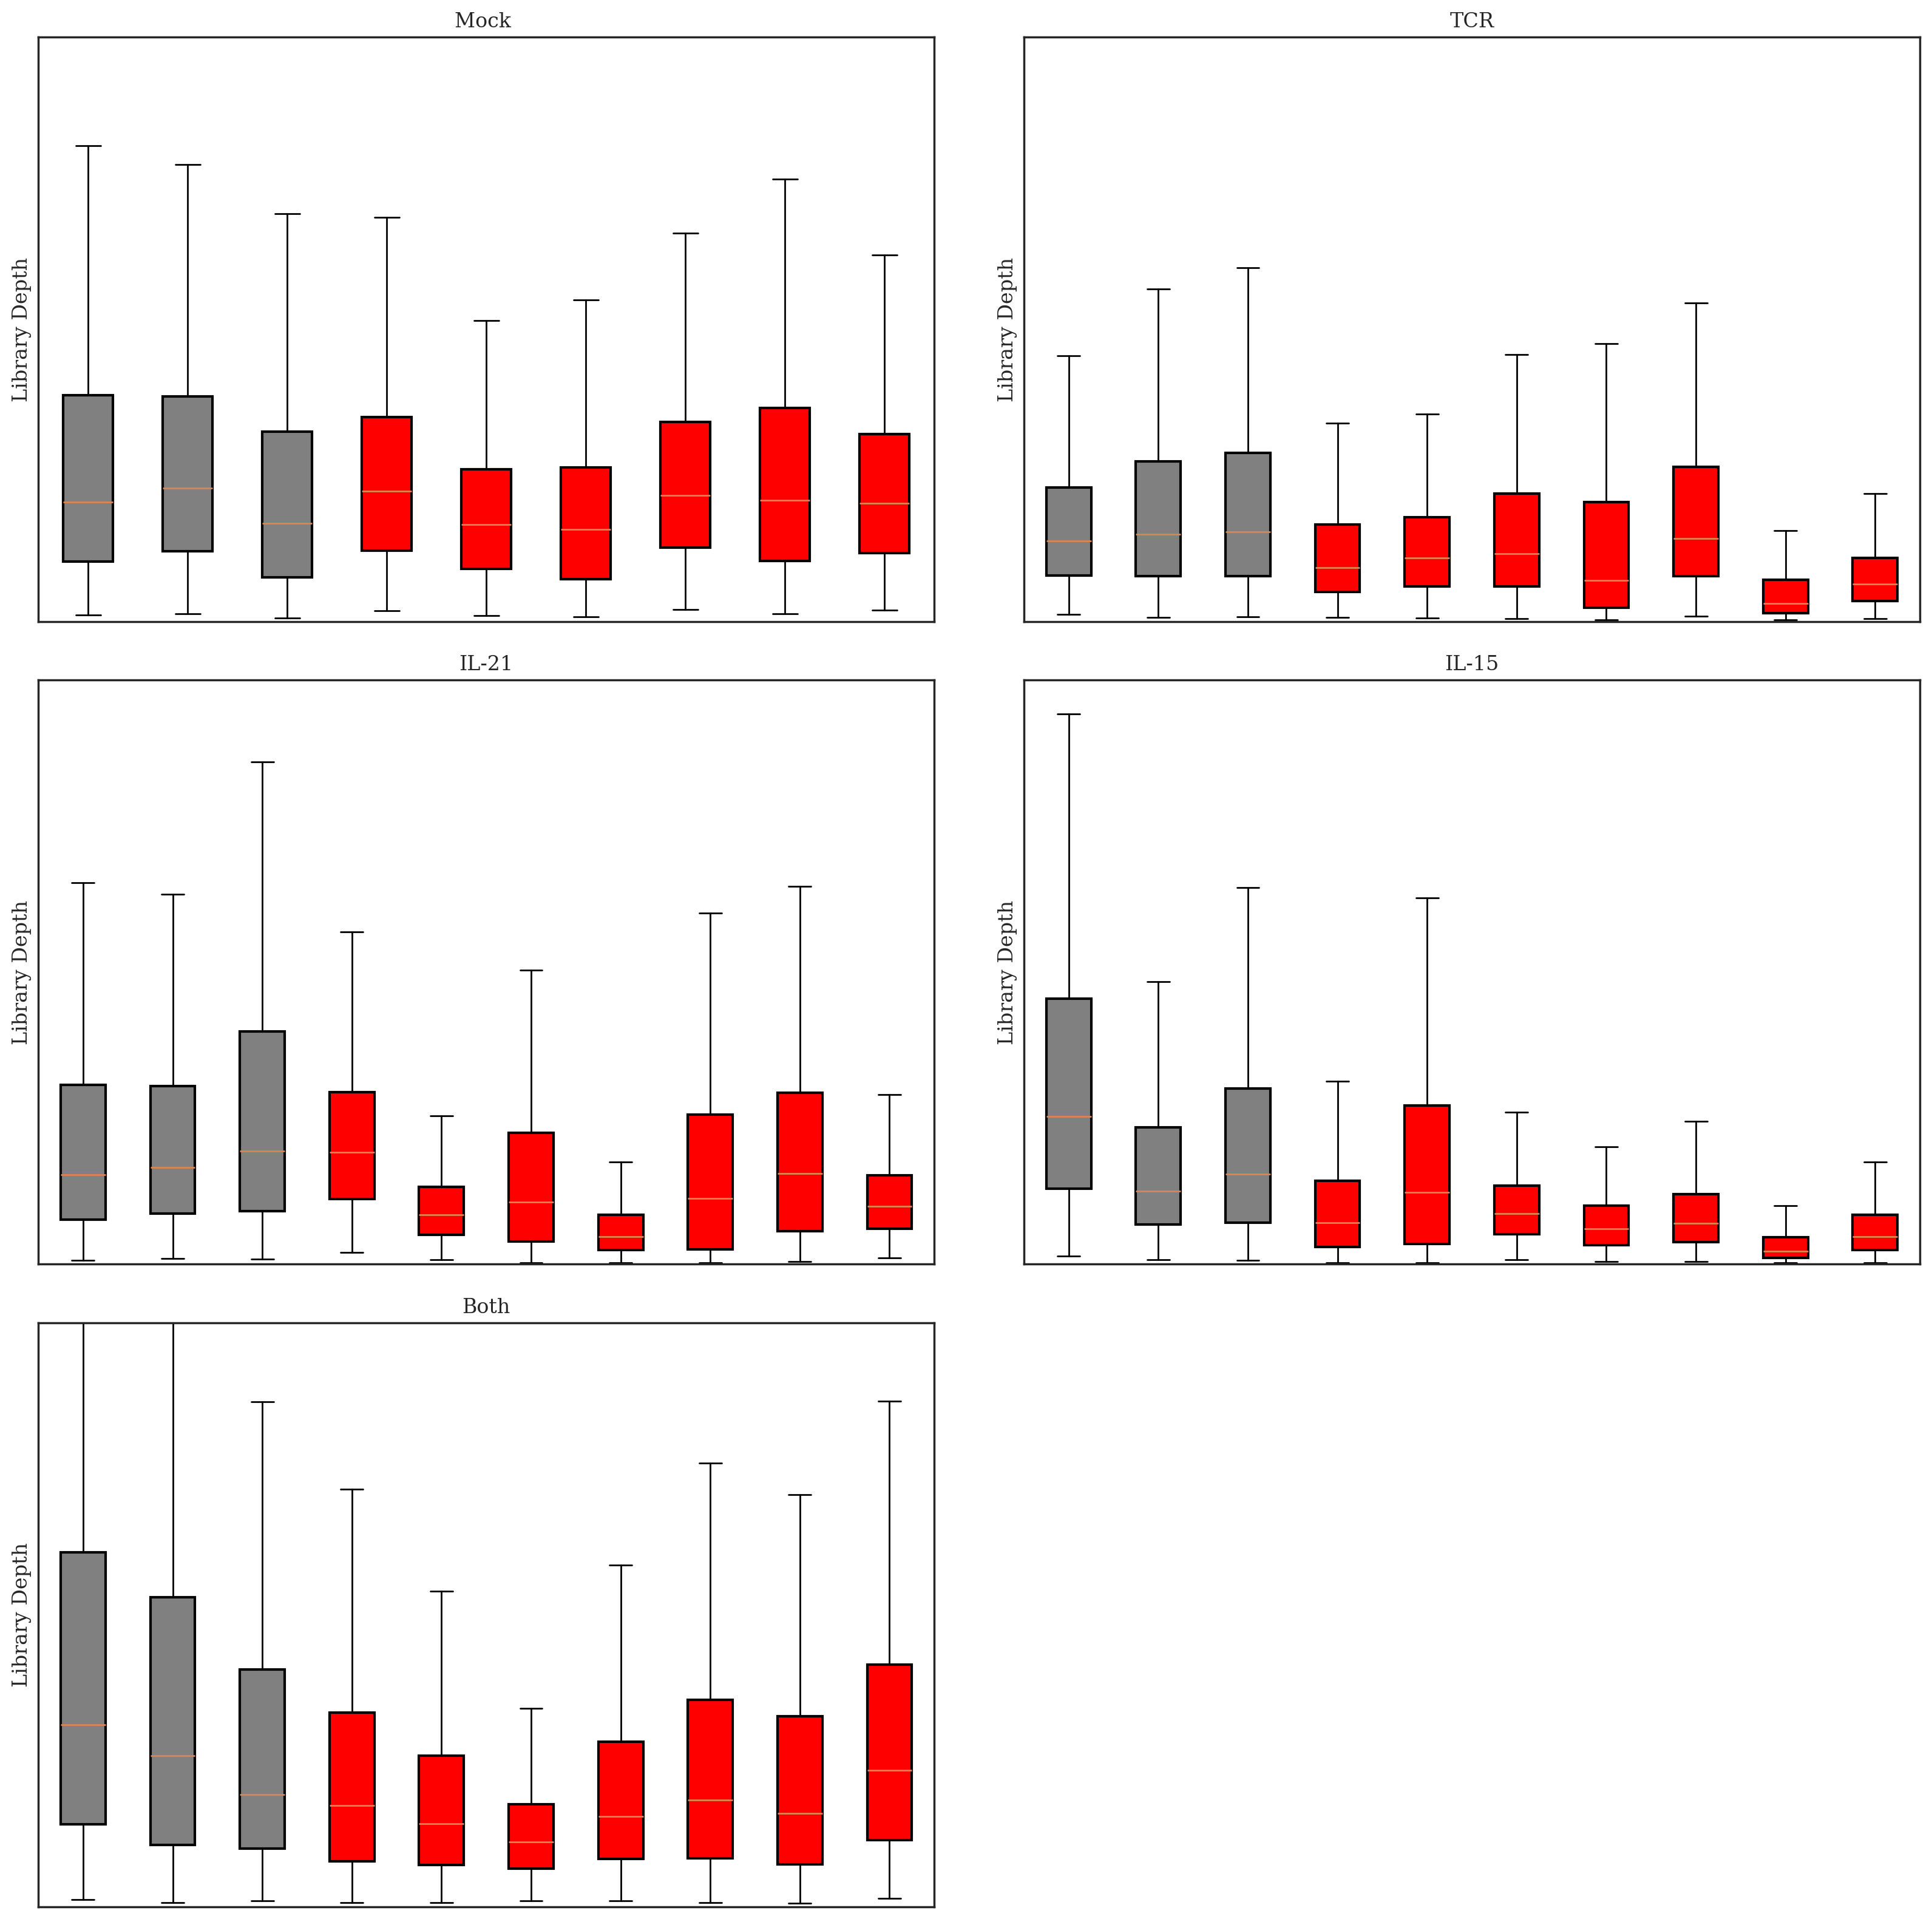

In [184]:
sns.set_theme(style="white", palette=None)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

con_list = ['Mock ', 'TCR', 'IL-21', 'IL-15', 'Both']

fig, ax = plt.subplots(3, 2, figsize=(20,20),sharey=all)
ax = ax.ravel()
for i,con in enumerate(con_list):
    run_box(df,condition=con,ax = ax[i],column_count = 'total_counts',yaxsis_info = True,y_lim = (0,4000),yticks = [],yticks_lab = [],showfliers= False)
fig.delaxes(ax[-1])
plt.subplots_adjust(wspace = 0.1, hspace=0.1)


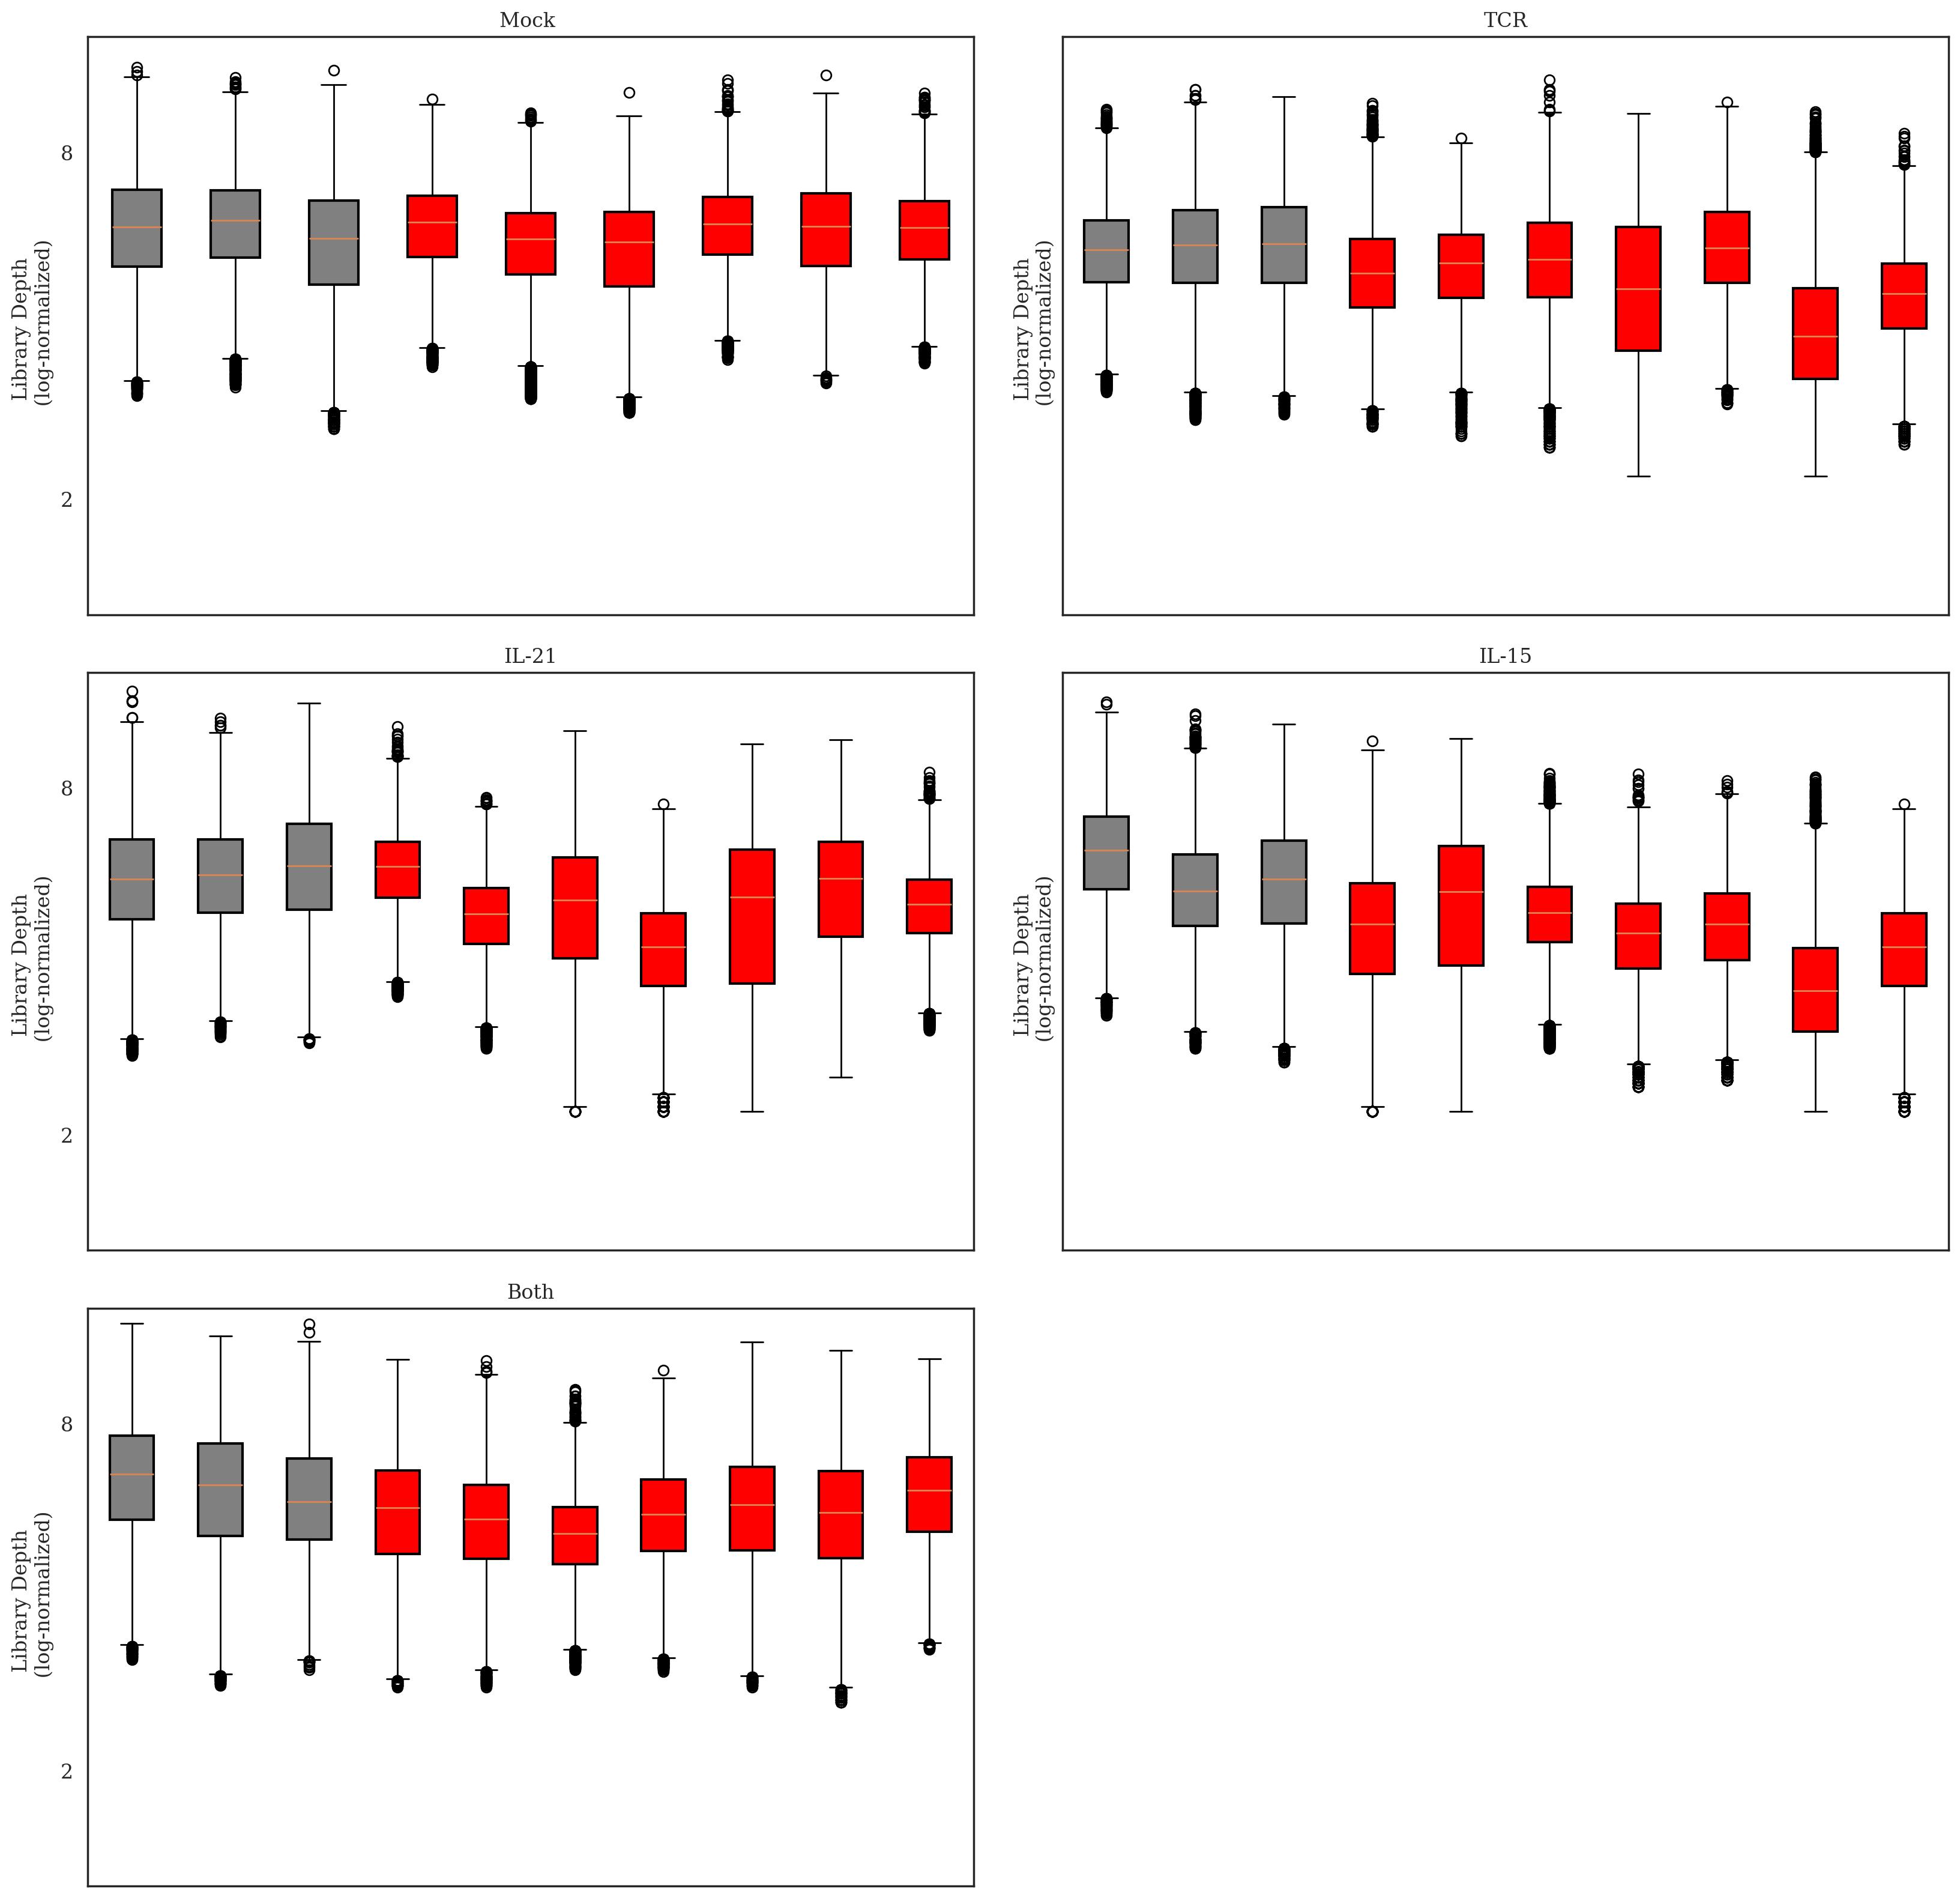

In [186]:
sns.set_theme(style="white", palette=None)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

con_list = ['Mock ', 'TCR', 'IL-21', 'IL-15', 'Both']

fig, ax = plt.subplots(3, 2, figsize=(20,20),sharey=all)
ax = ax.ravel()
for i,con in enumerate(con_list):
    run_box(df,condition=con,ax = ax[i])
fig.delaxes(ax[-1])
plt.subplots_adjust(wspace = 0.1, hspace=0.1)

# Strategies to Determine Similarity and Clustering
###

In [1]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pathout = '/data/kanferg/Sptial_Omics/projects/NguyenLab/spatialomicstoolkit/out_1'
andtata_in = sc.read_h5ad(os.path.join(pathout, "andata_filter_logNorm_hvg_leiden_harmony.h5ad"))
andtata_in

AnnData object with n_obs × n_vars = 664093 × 2000
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'outlier', 'cluster'
    var: 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_pca_Harmony', 'X_pca_before', 'spatial'
    varm: 'PCs'
    layers: 'counts', 'log'
    obsp: 'connectivities', 'distances'